# 2D multi-channel interpolation with local slopes regularization

## Author: M.Ravasi

This notebook applies 2D multi-channel interpolation with local slopes regularization to a 2D shot gather of the Missisipi Canyon dataset.

The notebook is organized as follows:

- data pre-processing
- multi-channel slope estimation
- 2D single-channel interpolation with sparsity promoting inversion
- 2D multi-channel interpolation with sparsity promoting inversion
- 2D multi-channel interpolation with sparsity promoting inversion and local slopes regularization.

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from pylops.basicoperators import *
from pylops.optimization.sparsity import fista
from pylops.utils.metrics import snr

from mcslopes.nmoinv import NMO
from mcslopes.plotting import plotting_style, plot_reconstruction_2d
from mcslopes.preprocessing import mask, subsample, gradient_data, fk_filter_design
from mcslopes.slopes import multicomponent_slopes_inverse

plotting_style()
USE_CUPY = True # use cupy or numpy

In [2]:
if USE_CUPY:
    import cupy as cp
    cp_asarray = cp.asarray
    cp_asnumpy = cp.asnumpy
else:
    cp = np
    cp_asarray = np.asarray
    cp_asnumpy = np.asarray

## Parameters

In [3]:
# pre-processing
apply_nmo = True # apply NMO correction prior to interpolation (True) or not (False)
vnmo = 1500 # NMO velocity (in m/s)
mask_thresh = 0.1 # time-space mask threshold
nfft_t, nfft_x = 2**11, 2**9 # lenght of frequency and wavenumber axis (used to compute gradients and perform FK transforms during data reconstruction)

# subsampling
nsub = 5 # subsampling factor

# fk masking
vel = 3200. # velocity
fmax = 70 # maximum frequency
critical = 1.00 # scaling to be applied to the f=k*v line used to create the mask
koffset = 0.002 # shift to be applied to the f=k*v line used to create the mask

# slope estimation
eps_slopeest = 1e3 # regularization factor for smoothing
niter_slopeest = 200 # number of iterations of lsqr

# interpolation
use_secondder = False # use first+second order derivative (True) or just first derivative (False) for interpolation
eps_slopes = 1e1 # regularization factor for slope consistency term
eps_fk = 1e-3 # regularization factor for sparsity term
niter = 200 # number of iterations of fista

In [4]:
# Define dictionaries for solvers
dict_slope_opt = dict(iter_lim=niter_slopeest) if not USE_CUPY else dict(niter=niter_slopeest)

## Data loading and preprocessing

We start by loading the data and applying the following pre-processing steps:

- filtering
- direct arrival removal
- time gain
- NMO correction (optional)
- define time-space mask

In [5]:
# Load data
fload = np.load('../../data/gom_data.npz')
x = fload['x']
t = fload['t']
data = fload['data']
dt = t[1] - t[0]
dx = x[1] - x[0]

# Ensure to have first and last trace
x = x[:(data.shape[1]//nsub)*nsub-nsub+1]
data = data[:, :(data.shape[1]//nsub)*nsub-nsub+1] 
nt, nx = data.shape

# Apply gain
gain = t / 2.
data = (data * gain[:, np.newaxis]).T

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


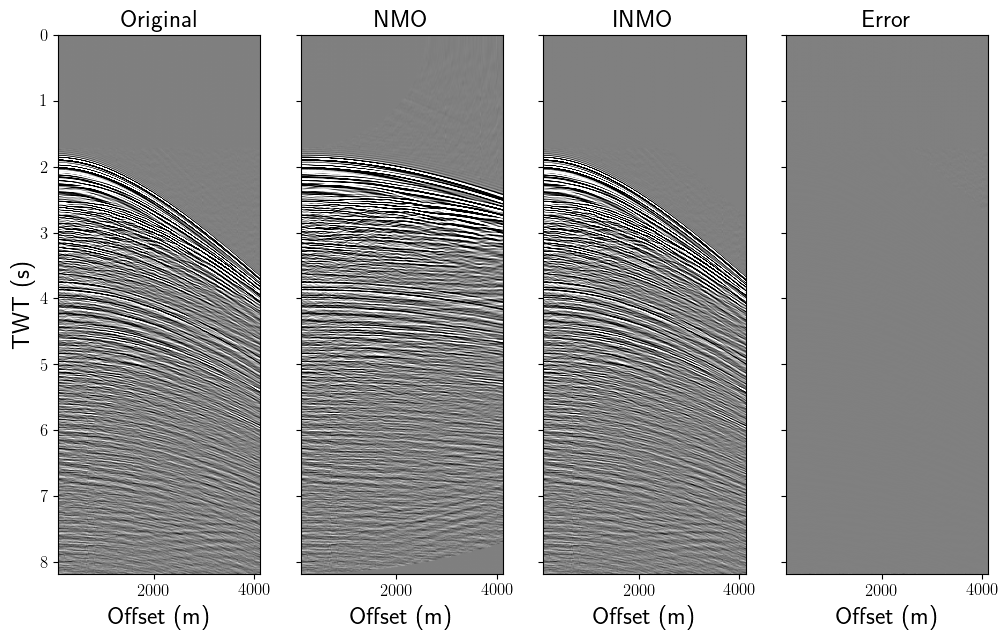

In [6]:
# Apply NMO (optional)
if apply_nmo:
    NMOOp = NMO(t, x, vnmo * np.ones(nt))

    datanmo = NMOOp @ data
    datainmo = NMOOp.div(datanmo.ravel()).reshape(data.shape)

    fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 7))
    axs[0].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
    axs[0].set_xlabel('Offset (m)')
    axs[0].set_ylabel('TWT (s)')
    axs[0].set_title('Original')
    axs[0].axis('tight')

    axs[1].imshow(datanmo.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
    axs[1].set_xlabel('Offset (m)')
    axs[1].set_title('NMO')
    axs[1].axis('tight')

    axs[2].imshow(datainmo.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
    axs[2].set_xlabel('Offset (m)')
    axs[2].set_title('INMO')
    axs[2].axis('tight')

    axs[3].imshow(data.T-datainmo.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
    axs[3].set_xlabel('Offset (m)')
    axs[3].set_title('Error')
    axs[3].axis('tight')
    
    # Overwrite data with nmo corrected data
    datanonmo = data.copy()
    data = datanmo.copy()

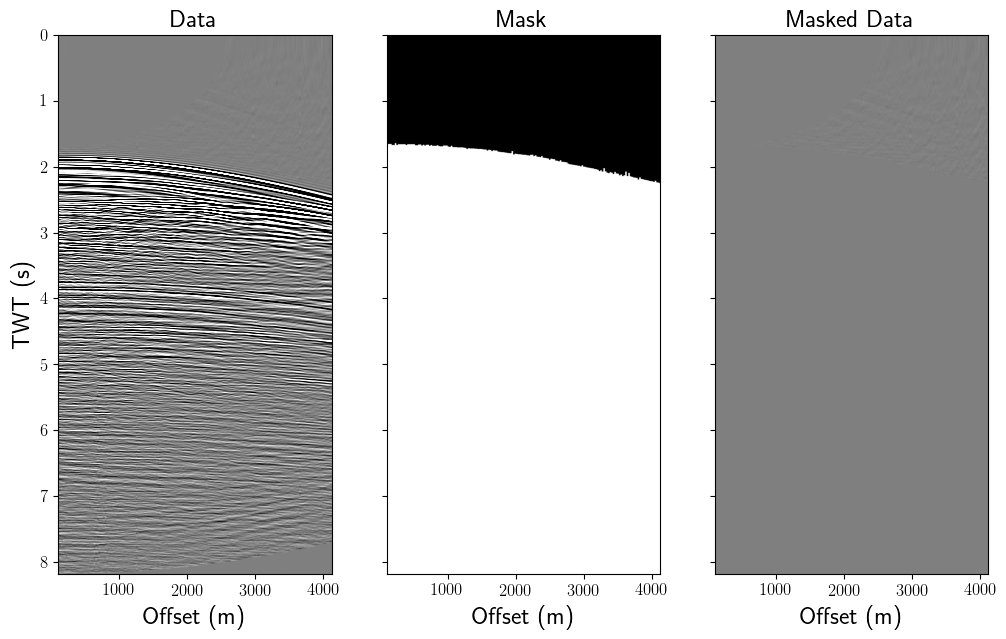

In [7]:
# Calculate time-space mask
maskt = mask(data, mask_thresh)
 
fig, axs = plt.subplots(1, 3, figsize=(12, 7), sharey=True)
axs[0].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Data')
axs[0].axis('tight')

axs[1].imshow(maskt.T, cmap='gray', vmin=0, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_title('Mask')
axs[1].axis('tight')

axs[2].imshow((1-maskt.T)*data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[2].set_xlabel('Offset (m)')
axs[2].set_title('Masked Data')
axs[2].axis('tight');

## Data decimation

We proceed now with defining the subsampling strategy and create the subsampled data we wish to interpolate

Spatial sampling: 115m


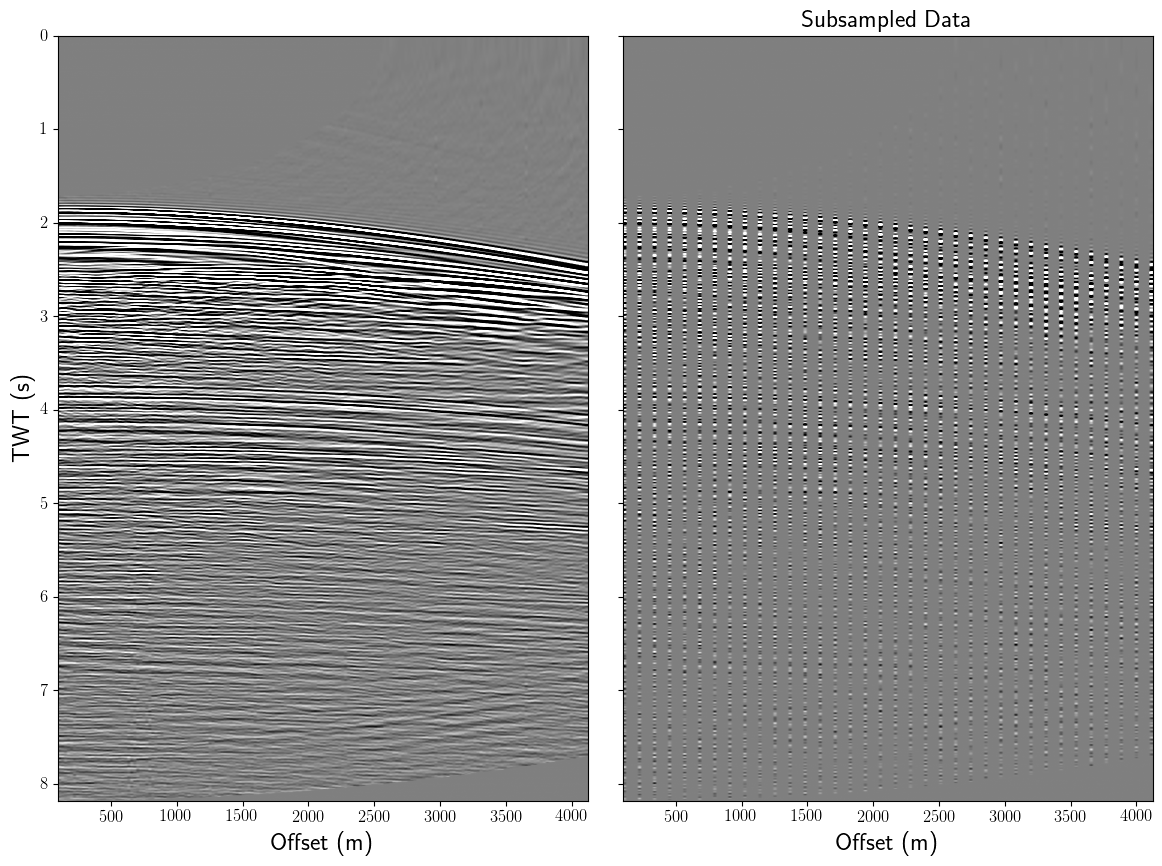

In [8]:
# Create restriction operator
print(f'Spatial sampling: {dx*nsub}m')
data_obs, data_mask, Rop = subsample(data, nsub)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].axis('tight')
axs[1].imshow(data_mask.data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_title('Subsampled Data')
axs[1].axis('tight')
plt.tight_layout()

## Spatial derivatives

We are now ready to create the first and second order gradients. In real life, these will be directly acquired and subjected to a similar pre-processing flow of the pressure data (*note: NMO correction must be performed as described in Robertsson et al., 2008*)

In [9]:
d1, d2, sc1, sc2, Fop, D1op, D2op, D, D1, D2, ks, f = gradient_data(data, nfft_x, nfft_t, dx, dt)
if apply_nmo: d1nonmo = gradient_data(datanonmo, nfft_x, nfft_t, dx, dt)[0]

# Decimate data
d_dec = Rop * data.ravel()
d1_dec = Rop * d1.ravel()
d2_dec = Rop * d2.ravel()

print(f'Scalings for 1st derivative data:{sc1:.2f}, and 2nd derivative data:{sc2:.2f}')

Scalings for 1st derivative data:36.84, and 2nd derivative data:326.73


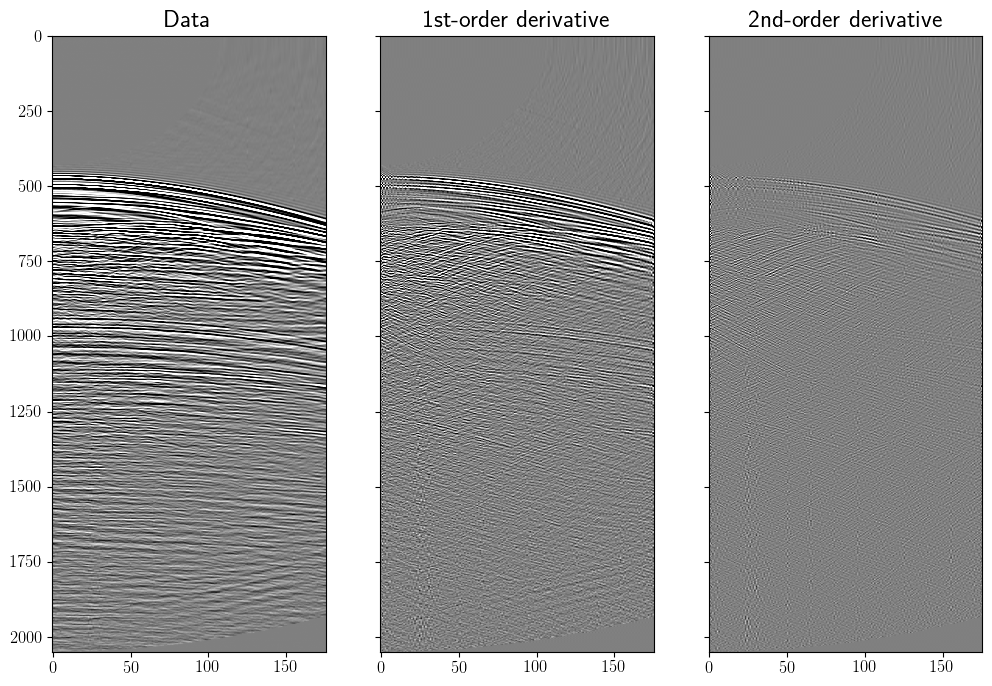

In [10]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 8))
axs[0].imshow(data.T, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0].set_title('Data')
axs[1].imshow(sc1 * d1.T, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[1].set_title('1st-order derivative')
axs[2].imshow(sc2 * d2.T, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[2].set_title('2nd-order derivative');

## FK mask design

Finally we design an FK mask that will be used to precondition all reconstruction processes, such that we ensure the reconstruct spectrum to lie within the expected signal cone.

In [11]:
mask_fk = fk_filter_design(f, ks, vel, fmax, critical=critical, koffset=koffset)
Mf = Diagonal(mask_fk.astype(np.complex).T.ravel(), dtype=np.complex)

/tmp/ipykernel_12883/2353276663.py:2: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Mf = Diagonal(mask_fk.astype(np.complex).T.ravel(), dtype=np.complex)


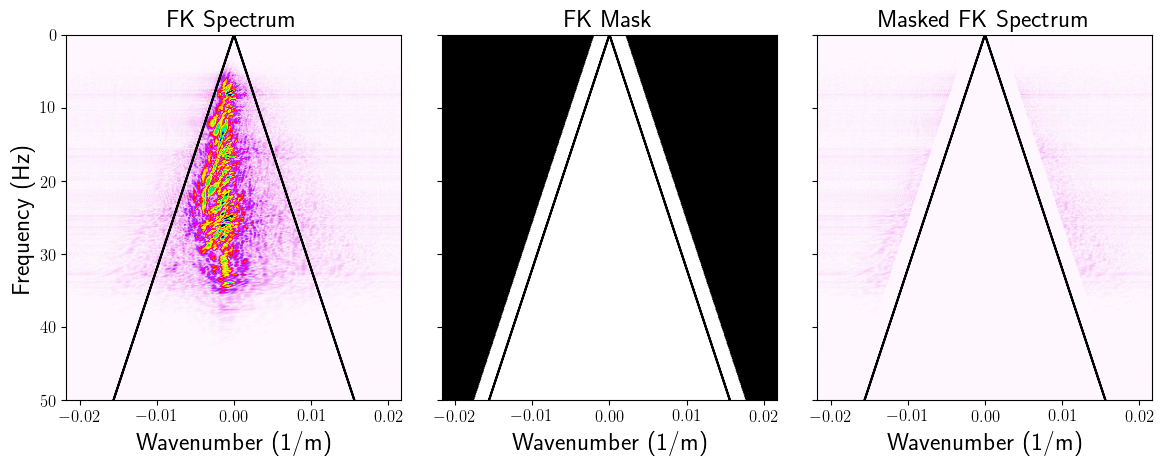

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
axs[0].imshow(np.abs(np.fft.fftshift(D)).T[nfft_t//2:], cmap='gist_ncar_r',
              aspect='auto', vmin=0, vmax=1e1,
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_t//2-1], f[0]))
axs[0].plot(f/vel, f,'k'), axs[0].plot(f/vel, -f,'k')
axs[0].set_xlim(-1/(2*dx), 1/(2*dx))
axs[0].set_xlabel('Wavenumber (1/m)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title('FK Spectrum')
axs[1].imshow(np.fft.ifftshift(mask_fk)[nfft_t//2:], cmap='gray',aspect='auto',
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_t//2-1], f[0]))
axs[1].plot(f/vel, f,'k'), axs[1].plot(f/vel, -f,'k')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx))
axs[1].set_xlabel('Wavenumber (1/m)')
axs[1].set_title('FK Mask')
axs[2].imshow(np.fft.fftshift((1-mask_fk)*np.abs(D).T)[nfft_t//2:], cmap='gist_ncar_r',
              aspect='auto', vmin=0, vmax=1e1,
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_t//2-1], f[0]))
axs[2].plot(f/vel, f,'k'), axs[2].plot(f/vel, -f,'k')
axs[2].set_xlim(-1/(2*dx), 1/(2*dx))
axs[2].set_ylim(50, 0)
axs[2].set_xlabel('Wavenumber (1/m)')
axs[2].set_title('Masked FK Spectrum')
plt.tight_layout()

## Multi-channel slope estimation

We are now ready to estimate local slopes using our synthetically created multi-channel data. We will do it first for the fully sampled data (this will be our benchmark) and then for the sparsely sampled data.

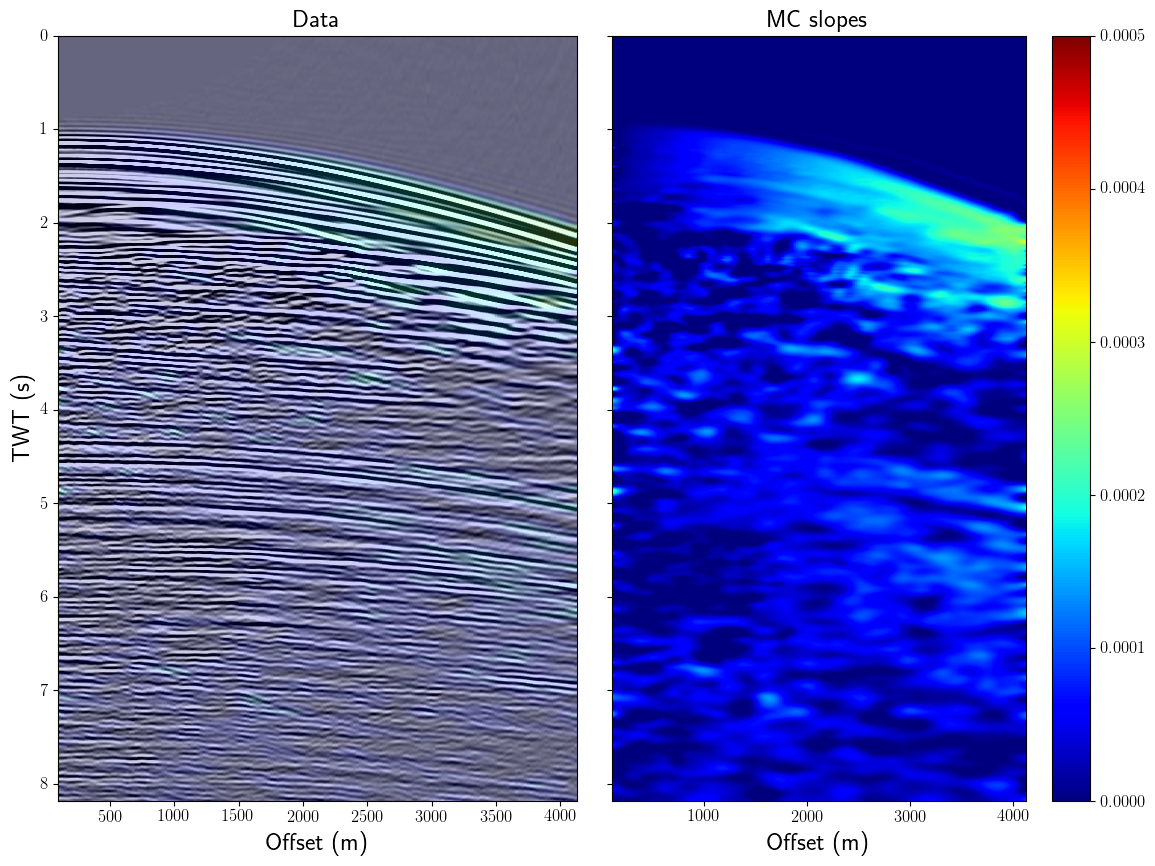

In [13]:
slope_mc = cp_asnumpy(multicomponent_slopes_inverse(cp_asarray(data), dx, dt, 
                                                    graddata=cp_asarray(d1), reg=eps_slopeest,
                                                    **dict_slope_opt))
if apply_nmo:
    slope_mcnonmo = cp_asnumpy(multicomponent_slopes_inverse(cp_asarray(datanonmo), dx, dt, 
                                                             graddata=cp_asarray(d1nonmo), reg=eps_slopeest,
                                                             **dict_slope_opt))

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(data[:, 300:1500].T, cmap='gray', 
              vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].imshow(cp_asnumpy(slope_mc)[300:1500], cmap='jet', 
              vmin=0, vmax=.5e-3, alpha=0.2, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Data')
axs[0].axis('tight')
im = axs[1].imshow(slope_mc[300:1500], cmap='jet', 
                   vmin=0, vmax=.5e-3, extent=(x[0], x[-1], t[-1], t[0]))
fig.colorbar(im, ax=axs[1])
axs[1].set_title('MC slopes')
axs[1].set_xlabel('Offset (m)')
axs[1].axis('tight')
plt.tight_layout()

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 73728 rows and 360448 cols
Regs=[<360448x360448 LinearOperator with dtype=float64>]
epsRs=[1000.0]
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 434176 rows and 360448 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 200
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        0.0000e+00         1.3026e+01     1.3026e+01
     2        0.0000e+00         1.2770e+01     1.2770e+01
     3        0.0000e+00         1.2481e+01     1.2481e+01
     4        0.0000e+00         1.2326e+01     1.2326e+01
     5        0.0000e+00         1.2208e+01     1.2208e+01
     6        0.0000e+00         1.2022e+01     1.2022e+01
     7        0.0000e+00         1.1827e+01     1.1827e+01
     8        0.0000e

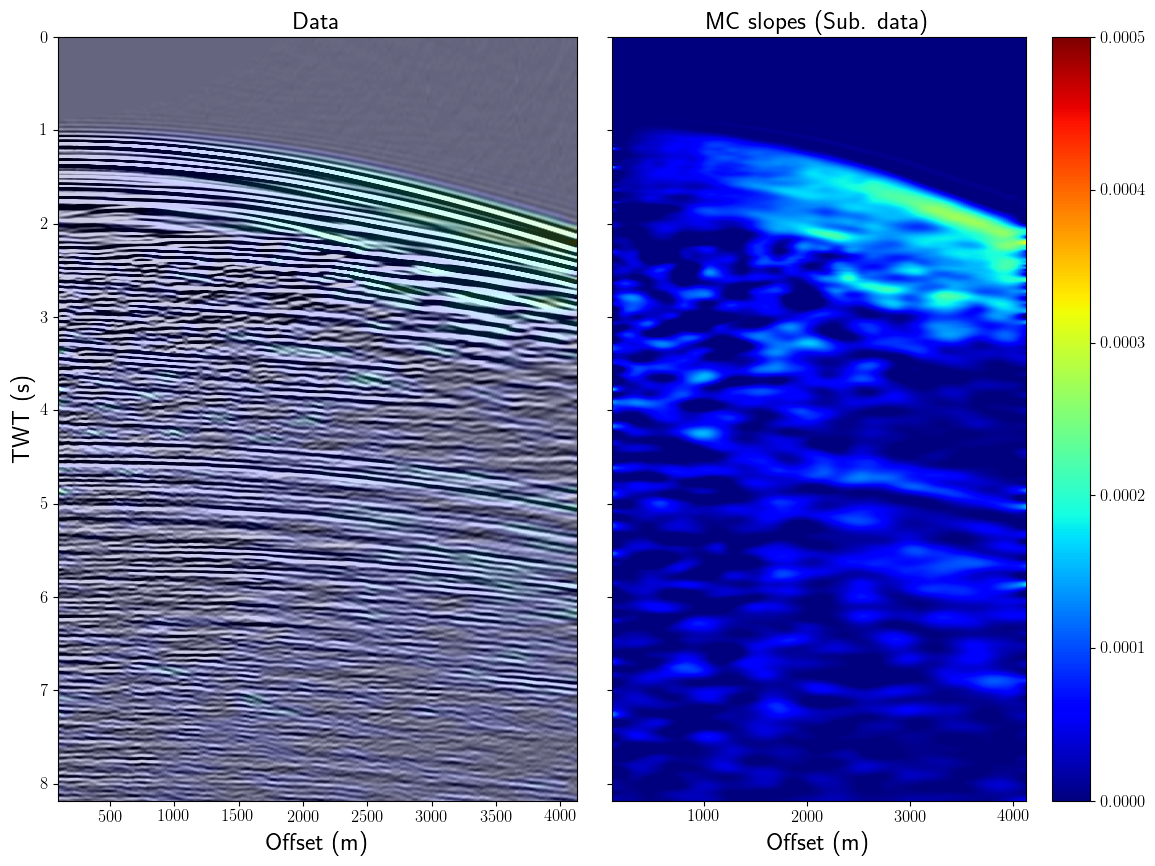

In [14]:
slope_mc1 = cp_asnumpy(multicomponent_slopes_inverse(cp_asarray(data), dx, dt, 
                                                     graddata=cp_asarray(d1), Rop=Rop,
                                                     reg=eps_slopeest,
                                                     **dict_slope_opt))
rcorr = np.array([sp.stats.pearsonr(slope_mc[:, ix], slope_mc1[:, ix])[0] for ix in range(nx)])

if apply_nmo:
    slope_mc1nonmo = cp_asnumpy(multicomponent_slopes_inverse(cp_asarray(datanonmo), dx, dt, 
                                                              graddata=cp_asarray(d1nonmo), Rop=Rop,
                                                              reg=eps_slopeest, show=True,
                                                              **dict_slope_opt))

    rcorr = np.array([sp.stats.pearsonr(slope_mcnonmo[:, ix], slope_mc1nonmo[:, ix])[0] for ix in range(nx)])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(data[:, 300:1500].T, cmap='gray', 
              vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].imshow(cp_asnumpy(slope_mc)[300:1500], cmap='jet', 
                         vmin=0, vmax=.5e-3, alpha=0.2, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Data')
axs[0].axis('tight')
im = axs[1].imshow(slope_mc1[300:1500], cmap='jet',
                   vmin=0, vmax=.5e-3, extent=(x[0], x[-1], t[-1], t[0]))
fig.colorbar(im, ax=axs[1])
axs[1].set_title('MC slopes (Sub. data)')
axs[1].set_xlabel('Offset (m)')
axs[1].axis('tight')
plt.tight_layout()

## 2D single-channel interpolation with sparsity promoting inversion

In [15]:
data0 = Rop * cp_asarray(data).ravel()
F0op  = Rop * Fop.H * Mf

with pylops.disabled_ndarray_multiplication():
    pinv0, _, _ = fista(F0op, data0, niter=niter, eps=eps_fk, 
                        eigsdict=dict(niter=5, tol=1e-2), show=True)

dinv0 = cp_asnumpy(np.real(Fop.H * Mf * pinv0).reshape(nx, nt))

/home/ravasim/miniconda3/envs/mcslopes/lib/python3.10/site-packages/pylops/basicoperators/restriction.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iavamask] = x.ravel()


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 73728 rows and 1048576 cols
eps = 1.000000e-03	tol = 1.000000e-10	niter = 200
alpha = 1.037540e+00	thresh = 5.187698e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -6.92e-03+8.48e-19j    1.334e+04   1.338e+04   1.721e+02
     2   -1.24e-02+1.52e-18j    6.169e+03   6.233e+03   9.599e+01
     3   -1.79e-02+2.20e-18j    2.616e+03   2.696e+03   7.727e+01
     4   -2.30e-02+2.82e-18j    1.008e+03   1.099e+03   5.913e+01
     5   -2.72e-02+3.33e-18j    3.300e+02   4.268e+02   4.399e+01
     6   -3.04e-02+3.72e-18j    7.764e+01   1.778e+02   3.165e+01
     7   -3.25e-02+3.99e-18j    1.141e+01   1.132e+02   2.137e+01
     8   -3.37e-02+4.13e-18j    1.174e+01   1.141e+02   1.275e+01
     9   -3.42e-02+4.18e-18j    2.151e+01   1.240e+02   5.890e+00
    10   -3.

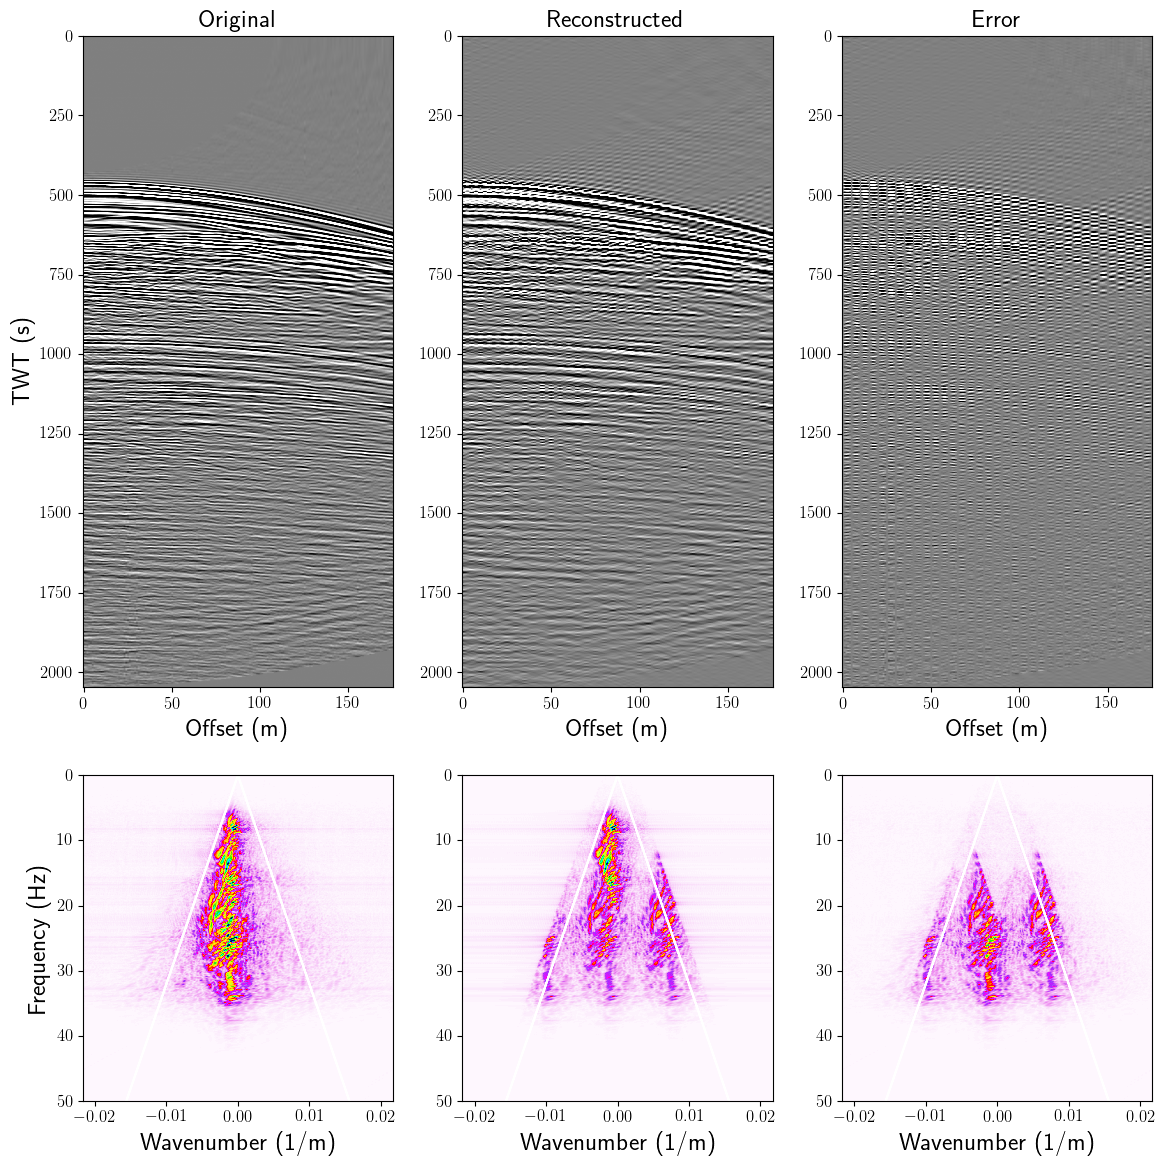

In [16]:
plot_reconstruction_2d(data, dinv0, Fop, dx, f, ks, vel)

## 2D multi-channel interpolation with sparsity promoting inversion

In [17]:
if not use_secondder:
    # only first derivative
    F1op = VStack([Rop*Fop.H, 
                   sc1*Rop*Fop.H*D1op]) * Mf
    data1 = cp_asarray(np.concatenate((d_dec, sc1*d1_dec), axis=0))
else:
    # 1st and 2nd
    F1op = VStack([Rop*Fop.H, 
                   sc1*Rop*Fop.H*D1op, 
                   sc2*Rop*Fop.H*D2op]) * Mf
    data1 = cp_asarray(np.concatenate((d_dec, sc1*d1_dec, sc2*d2_dec), axis=0))

pinv1, _, _ = fista(F1op, data1, niter=niter, eps=eps_fk, 
                    eigsdict=dict(niter=5, tol=1e-2), show=True)

dinv1 = cp_asnumpy(np.real(Fop.H * Mf * pinv1).reshape(nx, nt))

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 147456 rows and 1048576 cols
eps = 1.000000e-03	tol = 1.000000e-10	niter = 200
alpha = 1.160914e-01	thresh = 5.804568e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -7.75e-04+9.49e-20j    4.349e+04   4.350e+04   2.385e+01
     2   -1.53e-03+1.87e-19j    3.956e+04   3.957e+04   2.179e+01
     3   -2.47e-03+3.03e-19j    3.527e+04   3.529e+04   2.582e+01
     4   -3.59e-03+4.39e-19j    3.091e+04   3.093e+04   2.887e+01
     5   -4.85e-03+5.94e-19j    2.665e+04   2.669e+04   3.112e+01
     6   -6.24e-03+7.64e-19j    2.263e+04   2.267e+04   3.271e+01
     7   -7.74e-03+9.48e-19j    1.891e+04   1.896e+04   3.373e+01
     8   -9.32e-03+1.14e-18j    1.555e+04   1.560e+04   3.424e+01
     9   -1.10e-02+1.34e-18j    1.258e+04   1.264e+04   3.428e+01
    10   -1

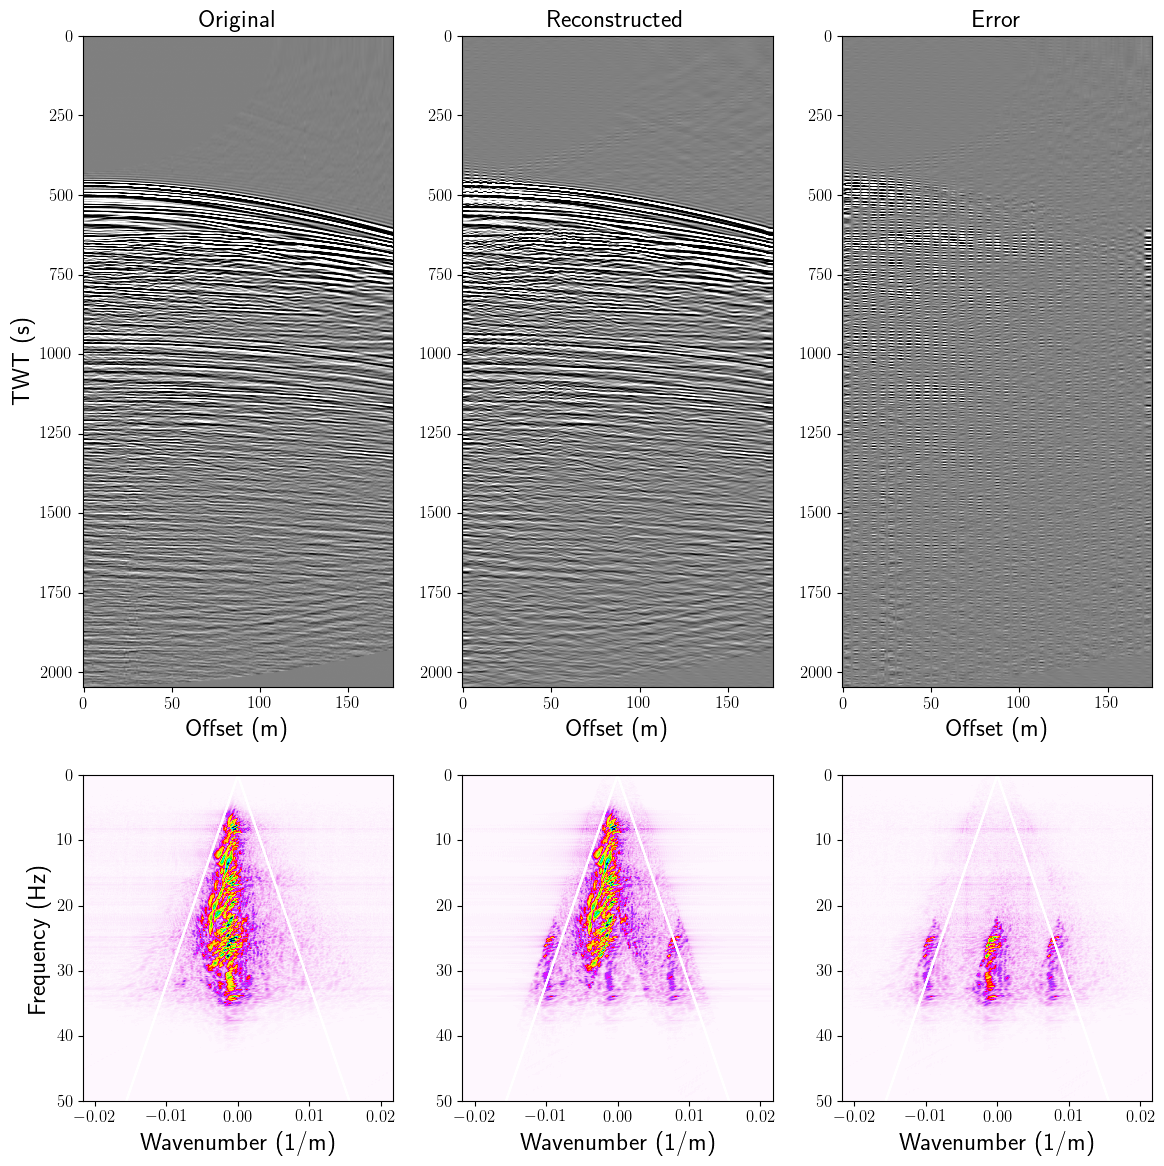

In [18]:
plot_reconstruction_2d(data, dinv1, Fop, dx, f, ks, vel)

## 2D multi-channel interpolation with sparsity promoting inversion and local slopes regularization

In [19]:
# Let's start by setting the slope regularization term
D1op0 = FirstDerivative(dims=(nx, nt), axis=0, sampling=dx, order=5, edge=True, dtype="complex128")
D1op1 = FirstDerivative(dims=(nx, nt), axis=1, sampling=dt, order=5, edge=True, dtype="complex128")
slope_D1op1 = Diagonal(cp_asarray(slope_mc1).T.ravel()) * D1op1
SRegop = D1op0 + slope_D1op1

In [20]:
if not use_secondder:
    # only first
    F2op = VStack([Rop*Fop.H, 
                   sc1*Rop*Fop.H*D1op, 
                   eps_slopes * SRegop * Fop.H]) * Mf
    data2 = cp_asarray(np.concatenate((d_dec, sc1*d1_dec, np.zeros(nt*nx)), axis=0))
else:
    # 1st and 2nd
    F2op = VStack([Rop*Fop.H, 
                   sc1*Rop*Fop.H*D1op, 
                   sc2*Rop*Fop.H*D2op,
                   eps_slopes * SRegop * Fop.H]) * Mf
    data2 = cp_asarray(np.concatenate((d_dec, sc1*d1_dec, sc2*d2_dec, np.zeros(nt*nx)), axis=0))

pinv2, _, _ = fista(F2op, data2, niter=niter, eps=eps_fk, 
                    eigsdict=dict(niter=5, tol=1e-2), show=True)

dinv2 = cp_asnumpy(np.real(Fop.H * Mf * pinv2).reshape(nx, nt))

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 507904 rows and 1048576 cols
eps = 1.000000e-03	tol = 1.000000e-10	niter = 200
alpha = 1.140777e-01	thresh = 5.703887e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -7.61e-04+9.32e-20j    4.360e+04   4.360e+04   2.344e+01
     2   -1.50e-03+1.84e-19j    3.982e+04   3.983e+04   2.120e+01
     3   -2.43e-03+2.98e-19j    3.576e+04   3.578e+04   2.495e+01
     4   -3.53e-03+4.32e-19j    3.168e+04   3.170e+04   2.773e+01
     5   -4.77e-03+5.84e-19j    2.773e+04   2.776e+04   2.977e+01
     6   -6.14e-03+7.52e-19j    2.401e+04   2.404e+04   3.120e+01
     7   -7.62e-03+9.33e-19j    2.057e+04   2.062e+04   3.213e+01
     8   -9.18e-03+1.12e-18j    1.747e+04   1.752e+04   3.262e+01
     9   -1.08e-02+1.32e-18j    1.470e+04   1.476e+04   3.271e+01
    10   -1

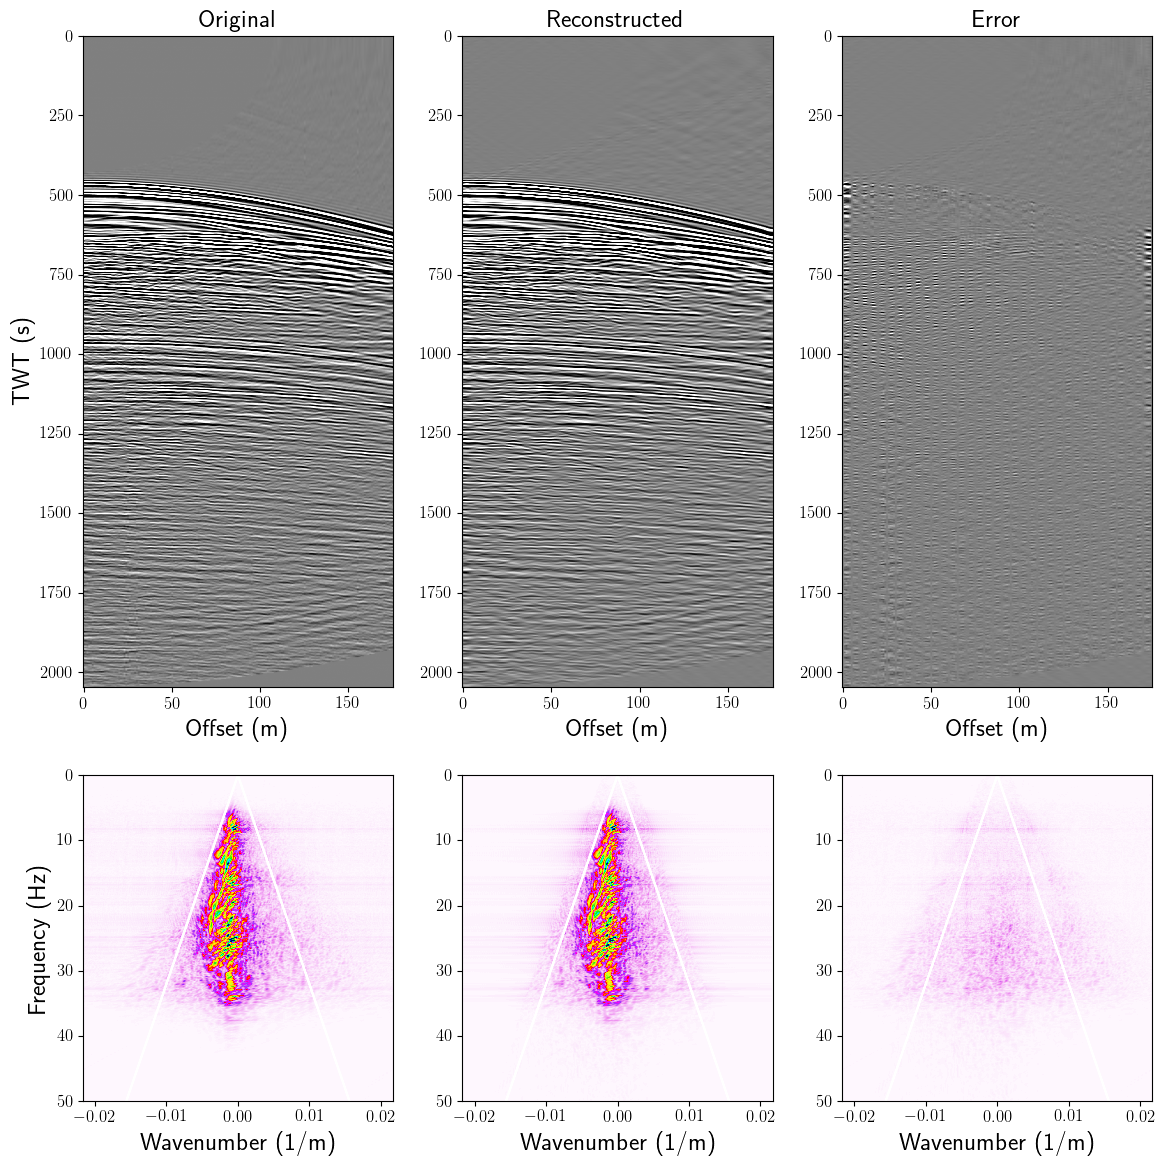

In [21]:
plot_reconstruction_2d(data, cp_asnumpy(dinv2), Fop, dx, f, ks, vel)

## Restore data (aka INMO correction)

Finally, if NMO correction was applied to the data prior to interpolation, we restore the data to their original domain

In [22]:
if apply_nmo:
    data = NMOOp.div(data.ravel()).reshape(data.shape)
    data_mask.data[:] = NMOOp.div(data_mask.data.ravel()).reshape(data.shape)
    dinv0 = NMOOp.div(dinv0.ravel()).reshape(data.shape)
    dinv1 = NMOOp.div(dinv1.ravel()).reshape(data.shape)
    dinv2 = NMOOp.div(dinv2.ravel()).reshape(data.shape)
    slope_mc = slope_mcnonmo
    slope_mc1 = slope_mc1nonmo
    
D = Fop * data
Dsub = Fop * data_mask.data
Dinv0 = Fop * dinv0
Dinv1 = Fop * dinv1
Dinv2 = Fop * dinv2

## Comparison

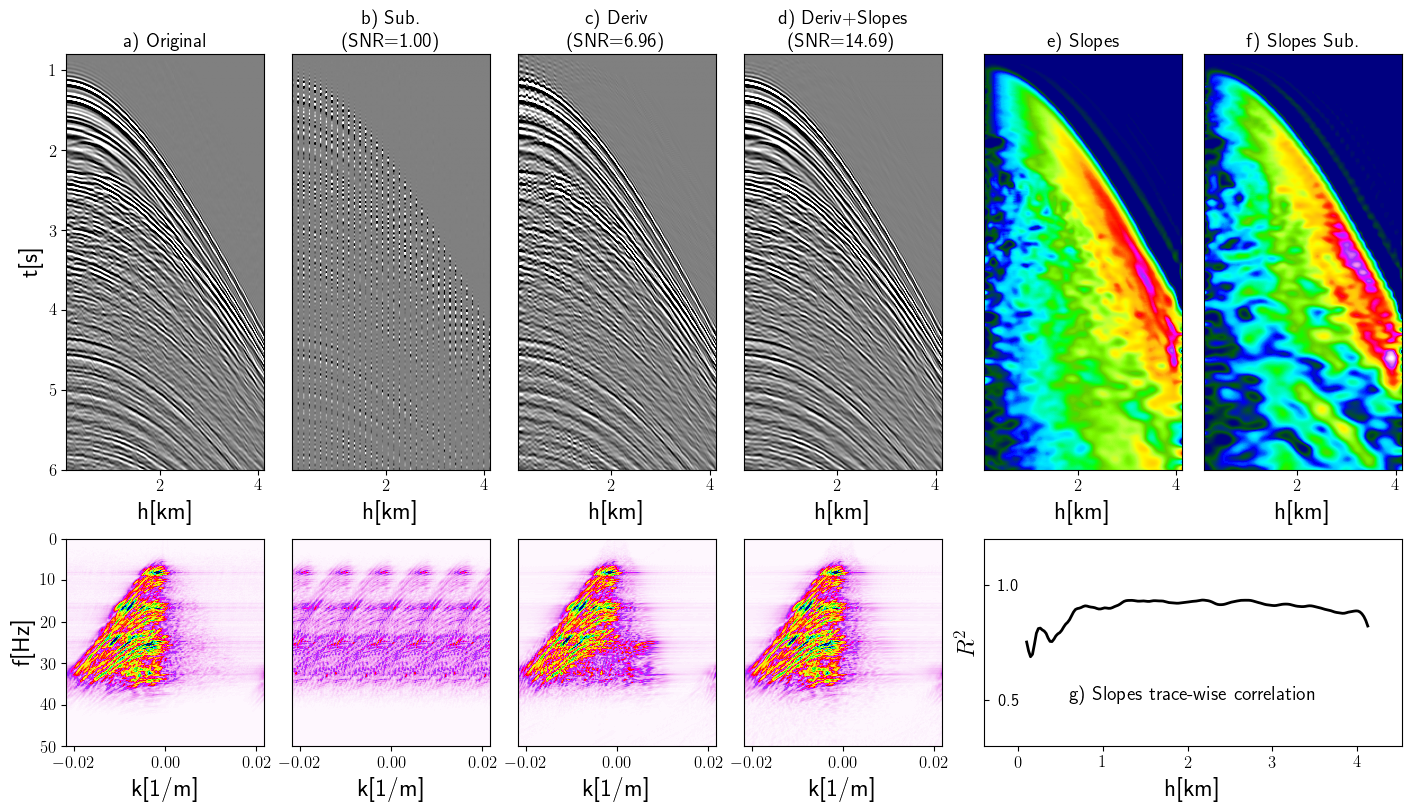

In [23]:
fig = plt.figure(constrained_layout=True, figsize=(14, 8))
axs = []
gs = fig.add_gridspec(3, 6)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))
axs.append(fig.add_subplot(gs[:2, 2]))
axs.append(fig.add_subplot(gs[:2, 3]))
axs.append(fig.add_subplot(gs[:2, 4]))
axs.append(fig.add_subplot(gs[:2, 5]))
axs.append(fig.add_subplot(gs[2:, 0]))
axs.append(fig.add_subplot(gs[2:, 1]))
axs.append(fig.add_subplot(gs[2:, 2]))
axs.append(fig.add_subplot(gs[2:, 3]))
axs.append(fig.add_subplot(gs[2:, 4:]))

axs[0].imshow(data[:, 300:1500].T, cmap='gray', aspect='auto', vmin=-2, vmax=2, 
              extent=(x[0]/1000, x[-1]/1000, t[-1], t[0]))
axs[0].set_title('a) Original', fontsize=14)
axs[0].axis('tight')
axs[0].set_xlabel('h[km]')
axs[0].set_ylabel('t[s]')
axs[0].set_ylim(6, 0.8)

axs[1].imshow(data_mask.data[:, 300:1500].T, cmap='gray', aspect='auto', vmin=-2, vmax=2, 
              extent=(x[0]/1000, x[-1]/1000, t[-1], t[0]))
axs[1].set_title(f'b) Sub. \n (SNR={snr(data, data_mask.data):.2f})', fontsize=14)
axs[1].axis('tight')
axs[1].set_ylim(6, 0.8)
axs[1].set_yticks([], [])
axs[1].set_xlabel('h[km]')

axs[2].imshow((maskt *dinv1)[:, 300:1500].T, cmap='gray', aspect='auto', vmin=-2, vmax=2, 
              extent=(x[0]/1000, x[-1]/1000, t[-1], t[0]))
axs[2].set_title(f'c) Deriv \n (SNR={snr(data, maskt * dinv1):.2f})', fontsize=14)
axs[2].axis('tight')
axs[2].set_ylim(6, 0.8)
axs[2].set_yticks([], [])
axs[2].set_xlabel('h[km]')

axs[3].imshow((maskt *dinv2)[:, 300:1500].T, cmap='gray', aspect='auto', vmin=-2, vmax=2, 
              extent=(x[0]/1000, x[-1]/1000, t[-1], t[0]))
axs[3].set_title(f'd) Deriv+Slopes \n (SNR={snr(data, maskt * dinv2):.2f})', fontsize=14)
axs[3].axis('tight')
axs[3].set_ylim(6, 0.8)
axs[3].set_yticks([], [])
axs[3].set_xlabel('h[km]')

axs[4].imshow(slope_mc[300:1500], cmap='gist_ncar', vmin=0, vmax=.8e-3, 
              extent=(x[0]/1000, x[-1]/1000, t[-1], t[0]))
axs[4].set_title(f'e) Slopes', fontsize=14);
axs[4].axis('tight')
axs[4].set_ylim(6, 0.8)
axs[4].set_yticks([], [])
axs[4].set_xlabel('h[km]')

axs[5].imshow(slope_mc1[300:1500], cmap='gist_ncar', vmin=0, vmax=.8e-3, 
              extent=(x[0]/1000, x[-1]/1000, t[-1], t[0]))
axs[5].set_title(f'f) Slopes Sub.', fontsize=14);
axs[5].axis('tight')
axs[5].set_ylim(6, 0.8)
axs[5].set_yticks([], [])
axs[5].set_xlabel('h[km]')

axs[6].imshow(np.fft.fftshift(np.abs(D).T)[nt//2:], cmap='gist_ncar_r',aspect='auto', vmin=0, vmax=5e0,
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[6].set_xlim(-1/(2*dx), 1/(2*dx));
axs[6].set_ylim(50, 0)
axs[6].set_ylabel('f[Hz]')
axs[6].set_xlabel('k[1/m]')

axs[7].imshow(np.fft.fftshift(np.abs(Dsub).T)[nt//2:], cmap='gist_ncar_r',aspect='auto', vmin=0, vmax=5e0,
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[7].set_xlim(-1/(2*dx), 1/(2*dx));
axs[7].set_ylim(50, 0)
axs[7].set_yticks([], [])
axs[7].set_xlabel('k[1/m]')

axs[8].imshow(np.fft.fftshift(np.abs(Dinv1).T)[nt//2:], cmap='gist_ncar_r',aspect='auto', vmin=0, vmax=5e0,
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[8].set_xlim(-1/(2*dx), 1/(2*dx));
axs[8].set_ylim(50, 0)
axs[8].set_yticks([], [])
axs[8].set_xlabel('k[1/m]')

axs[9].imshow(np.fft.fftshift(np.abs(Dinv2).T)[nt//2:], cmap='gist_ncar_r',aspect='auto', vmin=0, vmax=5e0,
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[9].set_xlim(-1/(2*dx), 1/(2*dx));
axs[9].set_ylim(50, 0)
axs[9].set_yticks([], [])
axs[9].set_xlabel('k[1/m]')

axs[10].plot(x/1000 , rcorr, 'k', lw=2)
axs[10].text(0.6, 0.5, 'g) Slopes trace-wise correlation', fontsize=14)
axs[10].set_xlim(-0.4, x[-1]/1000+0.4)
axs[10].set_ylim(0.3,1.2)
axs[10].set_xlabel('h[km]')
axs[10].set_ylabel(r'$R^2$')
axs[10].set_yticks([0.5, 1.], [0.5, 1.])
axs[10].tick_params(axis="y",direction="in", pad=-25)

plt.savefig(f'../../figs/gom/Reconstuction_sub{nsub}_nmo{apply_nmo}_usesecond{use_secondder}.eps');